In [ ]:
!pip install git+https://github.com/tensorflow/docs

import pathlib

import matplotlib.pyplot as plt
plt.style.use("dark_background")
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import sys
print(sys.version)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-l92zquuj
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-l92zquuj
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.002b81634107b8b3088097c791f2e827893ae2137_-cp36-none-any.whl size=146366 sha256=55e6865dda6e53848f0b1315d37165ec1409e9d3449b21c1118de5eab0eb3c40
  Stored in directory: /tmp/pip-ephem-wheel-cache-9vlfzw4m/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0
3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


In [ ]:
link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# dataset_path = keras.utils.get_file("auto-mpg.data",
# "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path = '/content/drive/My Drive/Colab Notebooks/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values="?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
print(dataset.isna().sum())
dataset = dataset.dropna()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


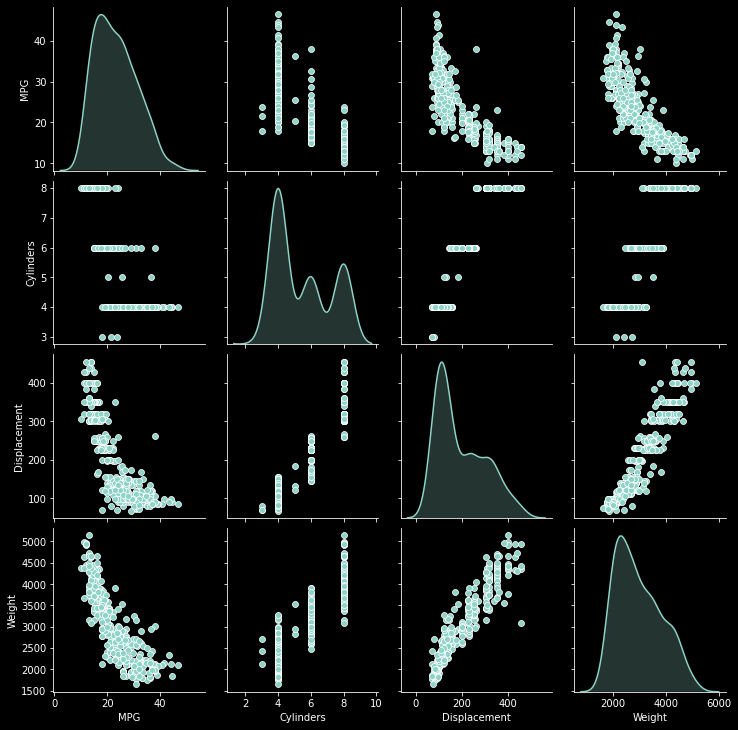

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
print('Train_stats: \n', train_stats)

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


Train_stats: 
               count         mean         std  ...     50%      75%     max
Cylinders     314.0     5.477707    1.699788  ...     4.0     8.00     8.0
Displacement  314.0   195.318471  104.331589  ...   151.0   265.75   455.0
Horsepower    314.0   104.869427   38.096214  ...    94.5   128.00   225.0
Weight        314.0  2990.251592  843.898596  ...  2822.5  3608.00  5140.0
Acceleration  314.0    15.559236    2.789230  ...    15.5    17.20    24.8
Model Year    314.0    75.898089    3.675642  ...    76.0    79.00    82.0
Origin        314.0     1.573248    0.800988  ...     1.0     2.00     3.0

[7 rows x 8 columns]


In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
'''
def build_model():
    model = keras.Sequential([
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dropout(0.5),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)  # no activation because that's what we want for regression
    ])
'''

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # no activation because that's what we want for regression
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',  # mean squared error
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])  # what to use to see how well the model is doing,
    # mean absolute error, mean squared error
    return model

model = build_model()

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print('Example result: \n', example_result)

Example result: 
 [[-0.39295042]
 [-0.43046397]
 [-0.28932136]
 [-0.32990843]
 [-0.87607473]
 [-0.187628  ]
 [-1.0288117 ]
 [-1.2189353 ]
 [-0.2638695 ]
 [-0.9068445 ]]


In [ ]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]) # make sure it prints a dot when it's training

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n Result: ', hist.tail())


Epoch: 0, loss:586.5293,  mae:22.9526,  mse:586.5293,  val_loss:582.7679,  val_mae:22.8535,  val_mse:582.7679,  
....................................................................................................
Epoch: 100, loss:6.2556,  mae:1.7224,  mse:6.2556,  val_loss:9.2638,  val_mae:2.3357,  val_mse:9.2638,  
....................................................................................................
Epoch: 200, loss:5.4027,  mae:1.5593,  mse:5.4027,  val_loss:9.2012,  val_mae:2.2991,  val_mse:9.2012,  
....................................................................................................
Epoch: 300, loss:4.7560,  mae:1.4484,  mse:4.7560,  val_loss:9.3502,  val_mae:2.3026,  val_mse:9.3502,  
....................................................................................................
Epoch: 400, loss:4.4597,  mae:1.3915,  mse:4.4597,  val_loss:10.0326,  val_mae:2.3951,  val_mse:10.0326,  
............................................................


 Result:           loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  2.776835  0.992258  2.776835  8.713017  2.169189  8.713017    995
996  2.754486  1.052794  2.754486  9.063980  2.237304  9.063980    996
997  2.730668  1.001992  2.730668  8.748601  2.169517  8.748601    997
998  2.904780  1.072472  2.904780  8.610460  2.132829  8.610460    998
999  2.706460  1.008869  2.706460  8.452352  2.107461  8.452352    999


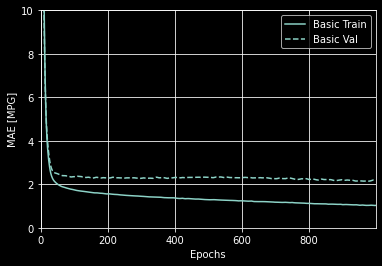

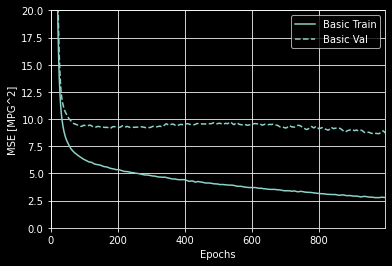

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n Result: ', hist.tail())

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.show()

plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')
plt.show()

model = build_model()

In [ ]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # waits 10 epochs of val_loss up to stop

early_history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plt.show()

print(early_stopping.history)

NameError: ignored

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.9786 - mae: 1.9533 - mse: 6.9786
Testing set Mean Abs Error:  1.95 MPG


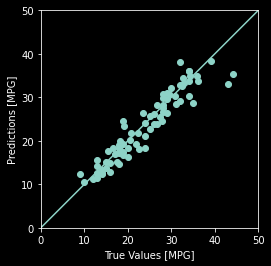

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

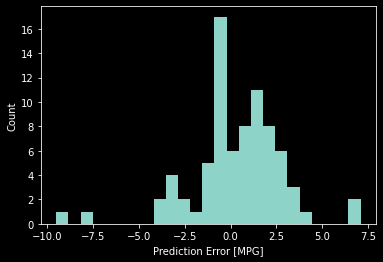

In [ ]:
# not a gaussian because dataset is small
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()